# Analyzing the Birthplaces of NHL Players and Their Closest NHL Team

# Imports 

In [319]:
import pandas as pd
from functions import *
%run functions.py
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from haversine import haversine, Unit # I could have used geopy.distance, too

## Data

In [3]:
all_players_df = pd.read_csv('data/player_info_df.csv', index_col=0)
all_na_players_df = pd.read_csv('data/all_players_full_info.csv', index_col=0)

In [4]:
player_gdf = pd.read_csv("data/player_gdf.csv", index_col=0)
player_gdf.drop(columns = ['link','Lat', 'Lng', 'geometry', 'nearest_geom', 'line'], inplace=True)

In [5]:
player_gdf.head(2)

,id,fullName,position,team_id,birthCity,birthStateProvince,birthCountry,nationality,team_name,city_province,coordinates,nearest_team,haversine_distance,close_to_any_team
0,8479414,Nathan Bastian,RW,1,Kitchener,ON,CAN,CAN,New Jersey Devils,"Kitchener,ON","43.4186,-80.4728",Toronto Maple Leafs,56.938564,True
1,8481740,Tyce Thompson,RW,1,Calgary,AB,CAN,CAN,New Jersey Devils,"Calgary,AB","51.05,-114.0667",Calgary Flames,1.076696,True


# Team Analysis

## How Many Players COULD Play for Closest Team

In [6]:
team_df = pd.DataFrame(player_gdf.groupby('nearest_team').id.count())

### Full teams

<AxesSubplot:xlabel='id'>

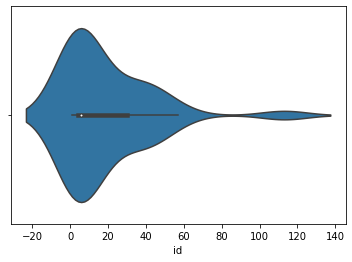

In [7]:
# distribution
sns.violinplot(x=team_df["id"])

In [8]:
# 11 teams would still be around!
# all 7 canadian teams plus one border team (Detroit, not Buffalo though)
team_df[team_df['id'] > 18].sort_values(by='id', ascending=False)

,id
nearest_team,
Toronto Maple Leafs,113
Detroit Red Wings,57
Minnesota Wild,44
Montréal Canadiens,44
Vancouver Canucks,43
Boston Bruins,40
Winnipeg Jets,40
Edmonton Oilers,31
Calgary Flames,29


In [9]:
print(f"{round(all_na_players_df.shape[0] / all_players_df.shape[0], 2)*100}% of players are from NA")

69.0% of players are from NA


In [10]:
# A team roster has 18 players, normally
team_roster_count = player_gdf.shape[0] / player_gdf.team_name.nunique()

In [11]:
# Since 70% of players are from NA, how many teams have 70% of a roster? 13
## how many teams have more than 13 players born close to them? Same amount as before
team_df[team_df['id'] > 13].sort_values(by='id', ascending=False)

,id
nearest_team,
Toronto Maple Leafs,113
Detroit Red Wings,57
Minnesota Wild,44
Montréal Canadiens,44
Vancouver Canucks,43
Boston Bruins,40
Winnipeg Jets,40
Edmonton Oilers,31
Calgary Flames,29


#### Are reasonably close

In [346]:
team_df_close = pd.DataFrame(player_gdf[player_gdf['close_to_any_team']==True].groupby('nearest_team').id.count())

In [347]:
# 8 teams have enough players born close to the team
team_df_close[team_df_close['id'] > 13].sort_values(by='id', ascending=False)

,id
nearest_team,
Toronto Maple Leafs,103
Detroit Red Wings,36
Vancouver Canucks,31
Montréal Canadiens,30
Minnesota Wild,26
Boston Bruins,23
Edmonton Oilers,18
Calgary Flames,17


## Few Players

In [12]:
# lots of teh southern teams have 5 or fewer players
# Every team has at least one NHL-quality player near them. That's frankly surprising
team_df[team_df['id'] < 13].sort_values(by='id')

,id
nearest_team,
San Jose Sharks,1
Vegas Golden Knights,1
Florida Panthers,1
Nashville Predators,2
Carolina Hurricanes,2
Tampa Bay Lightning,3
New Jersey Devils,4
Los Angeles Kings,4
Washington Capitals,4


# Players Playing for Home Team

In [13]:
home_team = player_gdf[player_gdf['team_name'] == player_gdf['nearest_team']]
# only 32 players play for their local team
print(home_team.shape[0])

32


In [14]:
# the Bruins and the Maples Leafs have the most hometown players
home_team_groupby = pd.DataFrame(home_team.groupby('team_name').id.count())
home_team_groupby.sort_values(by='id', ascending=False)

,id
team_name,
Toronto Maple Leafs,8
Boston Bruins,4
Detroit Red Wings,3
Minnesota Wild,3
Montréal Canadiens,3
Calgary Flames,2
Vancouver Canucks,2
Buffalo Sabres,1
Columbus Blue Jackets,1


## Which team has the highest proportion of local players on their team?

In [15]:
# since the Maple Leafs have the most local players, it makes sense that they would have the most local players
## which team has the highest proportion of their local players on their team?
### divide values in home_team_groupby by values in closest team
teams_w_local_players = list(home_team_groupby.index)
team_df_w_local_players = team_df[team_df.index.isin(teams_w_local_players)]

In [16]:
home_team_groupby['Total_local_players_in_NHL'] = team_df_w_local_players
percent_of_local_players = round(home_team_groupby['id'] / 
                                 home_team_groupby['Total_local_players_in_NHL'], 2) * 100
home_team_groupby['Percent_of_local_players_on_team'] = percent_of_local_players
home_team_groupby.sort_values(by='Percent_of_local_players_on_team', ascending=False)

,id,Total_local_players_in_NHL,Percent_of_local_players_on_team
team_name,,,
Nashville Predators,1,2,50.0
Columbus Blue Jackets,1,4,25.0
Los Angeles Kings,1,4,25.0
Pittsburgh Penguins,1,7,14.0
Boston Bruins,4,40,10.0
Buffalo Sabres,1,12,8.0
Calgary Flames,2,29,7.0
Minnesota Wild,3,44,7.0
Montréal Canadiens,3,44,7.0


# How many players have their closest team being Seattle? 

In [329]:
# Seattle will have a new team in 2021
# the new arena's coordinates '47.622, -122.354'

# getting all players who have their closest team being in northwest
players_from_nw = player_gdf[player_gdf['nearest_team'].isin([
                                                             'Vancouver Canucks'])].reset_index(drop=True)

In [339]:
dist_to_seattle = [haversine([float(players_from_nw['coordinates'][idx].split(",")[0]), 
                              float(players_from_nw['coordinates'][idx].split(",")[1])],
                              [47.622, -122.354],unit=Unit.MILES) for idx in range(len(players_from_nw))]
close_to_seattle = [x for x in dist_to_seattle if x < 60]
# two players were born within 60 miles of seattle 
len(close_to_seattle)

2

# How many players are REASONABLY close and PLAYING for their NHL team?

In [17]:
# I'll define reasonably close as 60 miles away (as the crow flies)
## 394 players are very close to A team
very_close_players_df = player_gdf[player_gdf['haversine_distance'] < 60]
very_close_players_df.shape[0]

394

In [18]:
# 188 players are not reasonably close to any NHL team (in addition to the 30% of non-American players)
all_na_players_df.shape[0] - very_close_players_df.shape[0]

188

In [19]:
# how many players are close to THEIR team? 24
very_close_local_players_df = player_gdf[(player_gdf['haversine_distance'] < 60) & 
                                        (player_gdf['team_name'] == player_gdf['nearest_team'])]
very_close_local_players_df.shape[0]

24

In [20]:
# which teams have the most local players?
very_close_groupby = pd.DataFrame(very_close_local_players_df.groupby('team_name').id.count())
very_close_groupby.sort_values(by='id', ascending=False)

,id
team_name,
Toronto Maple Leafs,7
Boston Bruins,3
Minnesota Wild,3
Detroit Red Wings,2
Montréal Canadiens,2
Vancouver Canucks,2
Buffalo Sabres,1
Columbus Blue Jackets,1
Edmonton Oilers,1


# Which States/Provinces Have the Most Players Per Capita?

## Engineering the Population Data

### US

In [240]:
# had to read files like this b/c it is xlsx file (https://stackoverflow.com/questions/65254535/xlrd-biffh-xlrderror-excel-xlsx-file-not-supported/65255334)
# I got the data from https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
us_pop_df = pd.read_excel(
    "data/nst-est2019-01.xlsx",
     engine='openpyxl', skiprows=3
)
us_pop_df2019 = us_pop_df[['Unnamed: 0', 2019]]
us_pop_df2019.columns = ['State_w_dot', 'Population'] # for 2019
us_pop_df2019.drop(index= us_pop_df2019.index[56:], inplace=True)
us_pop_df2019.drop(index= us_pop_df2019.index[:5], inplace=True)
us_pop_df2019['stateProvince'] = [x[1:] for x in us_pop_df2019['State_w_dot']]
us_pop_df2019['Country'] = 'USA'

In [241]:
# adding State Abbreviations
# from https://worldpopulationreview.com/states/state-abbreviations
us_abbrev = pd.read_csv("data/us_state_abbreviations.csv")

In [242]:
# adding state abbreviations to the data 
us_pop_df2019_abbrev = pd.merge(us_pop_df2019, us_abbrev, left_on='stateProvince', right_on='State')

### Canada

In [243]:
can_pop_df = pd.read_csv("data/1710000901-eng.csv", skiprows=5)
can_pop_df.drop(index= can_pop_df.index[15:], inplace=True)
can_pop_df.drop(index= can_pop_df.index[:2], inplace=True)
can_pop_df_2021 = can_pop_df[['Geography', 'Q1 2021']]
can_pop_df_2021.columns = ['Geography', 'Population']
can_pop_df_2021['Population'] = can_pop_df_2021['Population'].str.replace(',', '').astype(float)
can_pop_df_2021['stateProvince'] = [x[:-8] if "(map)" in x else x for x in can_pop_df_2021['Geography']]
can_pop_df_2021['Country'] = 'CAN'

In [244]:
# canadian abbreviations
can_abbrev = pd.read_excel("data/CountryCAN_e.xls")
can_abbrev['Province'] = [x.title() for x in can_abbrev['Province or Territory Name']]

In [245]:
# merging the two
can_pop_df_2021_abbrev = pd.merge(can_pop_df_2021, can_abbrev, left_on='stateProvince', right_on='Province')

### Merging the US and Canada Population data

In [246]:
us_can_pop_df_full = pd.concat([us_pop_df2019_abbrev, can_pop_df_2021_abbrev])

In [253]:
us_can_pop_df = us_can_pop_df_full[['Population', 'stateProvince', 'Code', 'Country']]

## Combining with the Player Data

In [254]:
player_province_data = pd.DataFrame(player_gdf.groupby('birthStateProvince').id.count())

In [255]:
us_can_player_pop_df = pd.merge(us_can_pop_df, player_province_data, 
                                left_on=['Code'], right_on=['birthStateProvince'])

In [259]:
us_can_player_pop_df.columns = ['Population', 'stateProvince', 'Code', 'Country', 'NHL_players']

In [287]:
# standardizing how many players there are per 100k inhabitants
us_can_player_pop_df['Players_100k_people'] = round((us_can_player_pop_df['NHL_players'] / us_can_player_pop_df['Population']) * 100000, 2) 

## Analyzing Players Per Capita

In [288]:
# keeping only the 41 states and provinces with players
us_can_player_pop_df.sort_values(by='Players_100k_people', ascending=False, inplace=True)
us_can_player_pop_df.shape

(41, 6)

<AxesSubplot:xlabel='Players_100k_people', ylabel='Code'>

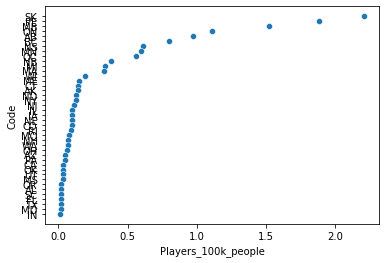

In [289]:
# plotting all states. Big disparity here!
sns.scatterplot(x = us_can_player_pop_df['Players_100k_people'], y = us_can_player_pop_df['Code'])

In [345]:
# Canadian provinces
us_can_player_pop_df[us_can_player_pop_df['Country'] == 'CAN']

,Population,stateProvince,Code,Country,NHL_players,Players_100k_people
38,1178832.0,Saskatchewan,SK,CAN,26,2.21
32,159819.0,Prince Edward Island,PE,CAN,3,1.88
37,1380935.0,Manitoba,MB,CAN,21,1.52
36,14755211.0,Ontario,ON,CAN,164,1.11
39,4436258.0,Alberta,AB,CAN,43,0.97
40,5153039.0,British Columbia,BC,CAN,41,0.80
33,979449.0,Nova Scotia,NS,CAN,6,0.61
35,8575944.0,Quebec,QC,CAN,48,0.56
34,782078.0,New Brunswick,NB,CAN,3,0.38


In [304]:
# Plotting the top 20 states/provinces
top20_us_can_player_pop_df = us_can_player_pop_df.iloc[0:20].reset_index(drop=True)

In [305]:
top20_us_can_player_pop_df

,Population,stateProvince,Code,Country,NHL_players,Players_100k_people
0,1178832.0,Saskatchewan,SK,CAN,26,2.21
1,159819.0,Prince Edward Island,PE,CAN,3,1.88
2,1380935.0,Manitoba,MB,CAN,21,1.52
3,14755211.0,Ontario,ON,CAN,164,1.11
4,4436258.0,Alberta,AB,CAN,43,0.97
5,5153039.0,British Columbia,BC,CAN,41,0.80
6,979449.0,Nova Scotia,NS,CAN,6,0.61
7,5639632.0,Minnesota,MN,USA,34,0.60
8,8575944.0,Quebec,QC,CAN,48,0.56
9,782078.0,New Brunswick,NB,CAN,3,0.38


In [308]:
# The average Saskatchewanian is 17 times more likely to player in the nhl than the average New Yorker
top20_us_can_player_pop_df['Players_100k_people'][0] / top20_us_can_player_pop_df['Players_100k_people'][17]

17.0

Text(0.5, 1.0, 'Number of NHL Players per 100,000 People in US and Canadian States and Provinces')

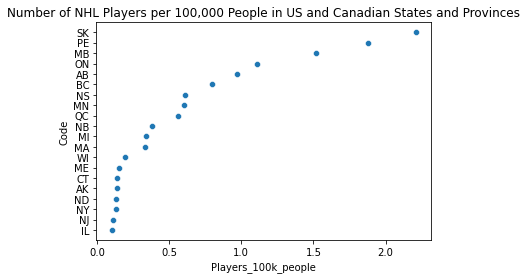

In [343]:
# viewing the top 20 states/provinces
ax = sns.scatterplot(x = top20_us_can_player_pop_df['Players_100k_people'], y = top20_us_can_player_pop_df['Code'])
ax.set_title("Number of NHL Players per 100,000 People in US and Canadian States and Provinces")